## **CT1-MLOPS COURSE GROUP ASSIGNMENT** ##

> **Use Case ::** Predicting Student Grade

> **Dataset Source ::** Kaggle - https://www.kaggle.com/datasets/rabieelkharoua/students-performance-dataset/data

> **Group No. ::** 12

## **STEP 10 :: MODEL MONITORING**

**Install alibi_detect library**

In [ ]:
pip install alibi alibi_detect --no-warn-script-location

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.1/522.1 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.5/381.5 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 7.3 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: pillow 11.0.0
    Uninstalling pillow-11.0.0:
      Successfully uninstalled pillow-11.0.0
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.43.0
    Uninstalling llvmlite-0.43.0:
      Successfully u

### **VIII.  Detecting the Drift between the Train Dataset and Production Dataset**

**About Data Drift -**
> Data drift is a change in the statistical properties of the input data used to train a machine learning model, which can lead to a model's performance degrading. It's important to detect data drift because it can significantly impact a model's accuracy and reliability.

> Reasons why data drift is important to predict:
>> **Model performance:** When a model's input data distribution changes, the model's assumptions become invalid, which can lead to suboptimal predictions and inaccurate results.
>> **Model failure:** Data drift is one of the two main reasons for silent model failure.
>> **Identifying causes:** Investigating the characteristics of an observed drift can help identify the causes of any performance change

**source -**
 - *https://www.evidentlyai.com/ml-in-production/data-drift#:~:text=Data%20drift%20is%20a%20shift,on%20or%20earlier%20production%20data.*
 - https://encord.com/blog/detect-data-drift/#:~:text=Akruti%20Acharya,predictions%20and%20potentially%20inaccurate%20results.
 - https://nannyml.readthedocs.io/en/stable/tutorials/detecting_data_drift.html#:~:text=The%20model%20has%20been%20trained,you%20to%20detect%20data%20drift.

**Steps Taken -**
1. We load the Train and Production datasets that are in parquet format from Github (repositry where the data is being version controlled).
2. The Tabular drift detector (**"TabularDrift"**) is initialized with the training data (trainDataset_df) and significane level of p=0.05 (setting threshold) to create a drift detector model.
3. The detector model is then used to **predict the overall drift** and **feature wise drift** between the Production dataset (prodDataset_df) and Train dataset.
4. To test the deviation between the distribution of features in train and production dataset we use Chi square and K-S test methods.

In [ ]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import alibi
from alibi_detect.cd import ChiSquareDrift, TabularDrift
from alibi_detect.saving import save_detector, load_detector

# Setting the no. of records display in output and no. of characters displayed in a column
pd.options.display.max_columns = 20 # Max 20 rows displayed. First and Last 10 rows shown, if limit exceeded
pd.options.display.max_rows = 20 # Max 20 columns displayed. First and Last 10 columns shown, if limit exceeded
pd.options.display.max_colwidth = 80 # Max of 80 characters displayed per column. Post limit truncated with an ellipsis (...)
np.set_printoptions(precision=4, suppress=True) # Displays only upto 4 decimals.

# Using "warnings" module to suppress/ignore warnings thrown by methods
import warnings
warnings.filterwarnings('ignore')

#### **Importing the Train and Production Dataset from Github**

In [ ]:
# Importing the Train dataset and Production Dataset stored in parquet format from github
trainDataset_df = pd.read_parquet("https://raw.githubusercontent.com/Sri1911/ML-Ops-ISB-Proj/main/Dataset/TrainDataset/completeTrainData.parquest")
prodDataset_df = pd.read_parquet("https://raw.githubusercontent.com/Sri1911/ML-Ops-ISB-Proj/main/Dataset/ProductionDataset/completeProductionData.parquest")

In [ ]:
trainDataset_df

,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GradeClass
607,18,1,2,2,0.260204,15,0,3,1,1,1,0,3.0
415,15,0,0,1,16.799964,27,0,2,1,1,0,0,4.0
273,18,0,0,1,2.325474,16,0,3,0,0,0,1,4.0
1511,17,0,0,3,1.738791,24,0,1,1,0,0,0,4.0
780,15,0,0,3,13.386967,18,0,4,0,1,1,0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,15,0,1,0,13.092424,13,1,1,0,0,0,0,4.0
1095,16,0,0,2,2.159249,19,0,4,0,1,0,0,4.0
1130,16,1,0,2,3.572578,14,1,2,1,1,0,0,3.0
1294,18,0,3,2,4.402585,20,0,3,0,0,0,0,4.0


In [ ]:
trainDataset_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1435 entries, 607 to 860
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                1435 non-null   int64  
 1   Gender             1435 non-null   int64  
 2   Ethnicity          1435 non-null   int64  
 3   ParentalEducation  1435 non-null   int64  
 4   StudyTimeWeekly    1435 non-null   float64
 5   Absences           1435 non-null   int64  
 6   Tutoring           1435 non-null   int64  
 7   ParentalSupport    1435 non-null   int64  
 8   Extracurricular    1435 non-null   int64  
 9   Sports             1435 non-null   int64  
 10  Music              1435 non-null   int64  
 11  Volunteering       1435 non-null   int64  
 12  GradeClass         1435 non-null   float64
dtypes: float64(2), int64(11)
memory usage: 157.0 KB


In [ ]:
prodDataset_df

,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GradeClass
886,15,1,0,3,18.973082,29,1,1,1,0,0,0,4.0
1740,18,1,1,0,10.281614,10,0,3,1,0,0,0,2.0
672,16,1,1,1,2.369234,0,1,2,1,0,0,0,1.0
973,17,1,1,2,5.045057,14,1,1,1,0,0,0,4.0
579,16,1,0,2,14.967505,5,0,3,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1992,17,0,2,2,5.419264,6,0,1,0,0,0,0,2.0
2127,17,1,0,4,10.103314,1,0,3,1,1,0,0,0.0
1181,18,0,3,3,10.617181,15,0,0,0,1,1,0,4.0
637,17,0,1,1,8.630162,25,0,1,0,0,0,1,4.0


In [ ]:
prodDataset_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 479 entries, 886 to 700
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                479 non-null    int64  
 1   Gender             479 non-null    int64  
 2   Ethnicity          479 non-null    int64  
 3   ParentalEducation  479 non-null    int64  
 4   StudyTimeWeekly    479 non-null    float64
 5   Absences           479 non-null    int64  
 6   Tutoring           479 non-null    int64  
 7   ParentalSupport    479 non-null    int64  
 8   Extracurricular    479 non-null    int64  
 9   Sports             479 non-null    int64  
 10  Music              479 non-null    int64  
 11  Volunteering       479 non-null    int64  
 12  GradeClass         479 non-null    float64
dtypes: float64(2), int64(11)
memory usage: 52.4 KB


#### **Defining the Features and sorting as "Numerical" and "Categorical"**

In [ ]:
x_features = ['Age', 'Gender', 'Ethnicity', 'ParentalEducation',
       'StudyTimeWeekly', 'Absences', 'Tutoring', 'ParentalSupport',
       'Extracurricular', 'Sports', 'Music', 'Volunteering']
x_features

['Age',
 'Gender',
 'Ethnicity',
 'ParentalEducation',
 'StudyTimeWeekly',
 'Absences',
 'Tutoring',
 'ParentalSupport',
 'Extracurricular',
 'Sports',
 'Music',
 'Volunteering']

In [ ]:
catg_vars = ['Age','Gender', 'Ethnicity', 'ParentalEducation',
        'Tutoring', 'ParentalSupport', 'Extracurricular', 'Sports', 'Music', 'Volunteering']
catg_vars

['Age',
 'Gender',
 'Ethnicity',
 'ParentalEducation',
 'Tutoring',
 'ParentalSupport',
 'Extracurricular',
 'Sports',
 'Music',
 'Volunteering']

In [ ]:
num_vars = list(set(x_features) - set(catg_vars))
num_vars

['StudyTimeWeekly', 'Absences']

#### **Measure the drift**

In [ ]:
categories_per_feature = {x_features.index(f): None for f in catg_vars}

In [ ]:
# Initializing the tabular drift detector with significance level - p_val set to 0.5 for detecting drift
cd = TabularDrift(trainDataset_df[x_features].values,
                  p_val=0.05,
                  categories_per_feature=categories_per_feature)

In [ ]:
filepath = 'datadrift'  # change to directory where detector is saved
save_detector(cd, filepath, legacy = True)

In [ ]:
cd = load_detector(filepath)

In [ ]:
# Detecting the drift w.r.t the Production dataset
drift_predictor = cd.predict(prodDataset_df[x_features].to_numpy())

In [ ]:
# Overall status of the drift between the two datasets with 0:No and 1:Yes
drift = drift_predictor['data']['is_drift']
drift

0

In [ ]:
# p_val for each feature
p_val = drift_predictor['data']['p_val']
p_val

array([0.9175, 0.0421, 0.2134, 0.7817, 0.6483, 0.3756, 0.1785, 0.6813,
       0.3822, 0.5552, 0.5177, 0.9797], dtype=float32)

In [ ]:
# Threshold value associated with the two dataset as per the drift detector
threshold = drift_predictor['data']['threshold']
threshold

0.004166666666666667

#### **Chi Square Test for Numeric and Kolmogorov-Smirnov (K-S) Test for Categorical Features**
Both the Chi test and K-S test are performed to Determines if a variable is likely to come from a given distribution.

> **Chi Square Test-**
The Chi Square value indicates the deviation between the observed and expected frequencies for categoricl features.
>> A **higher** values indicates potential drift and a **lower** value indicates less deviation.

**source -** *https://www.scribbr.com/statistics/chi-square-distribution-table/#:~:text=A%20chi%2Dsquare%20distribution%20is,range%20is%200%20to%20%E2%88%9E.*

> **K-S Test-**
The K-S test measures the maximum difference between two cumulative distributions for numerical features.
>> A **lower** K-S value indicates smaller differences , while a **higher** K-S value suggests a larger deviation.

**source -** *https://towardsdatascience.com/evaluating-classification-models-with-kolmogorov-smirnov-ks-test-e211025f5573*


In [ ]:
stat = []
p_val = []
fname = []
stat_val = []

for f in range(cd.n_features):
    stat.append('Chi2') if f in list(categories_per_feature.keys()) else stat.append('K-S')
    stat_val.append(drift_predictor['data']['distance'][f])
    p_val.append(drift_predictor['data']['p_val'][f])
    fname.append(x_features[f])

summary_df = pd.DataFrame({
    "Feature Name": fname,
    "Statistical Test": stat,
    "Statistical Value": stat_val,
    "P-Value": [f'{val:.3f}' for val in p_val],
    "Drift Detected": ["Yes" if val < 0.05 else "No" for val in p_val]
})

In [ ]:
summary_df

,Feature Name,Statistical Test,Statistical Value,P-Value,Drift Detected
0,Age,Chi2,0.506300,0.918,No
1,Gender,Chi2,4.131737,0.042,Yes
2,Ethnicity,Chi2,4.487848,0.213,No
3,ParentalEducation,Chi2,1.749583,0.782,No
4,StudyTimeWeekly,K-S,0.038470,0.648,No
5,Absences,K-S,0.047705,0.376,No
6,Tutoring,Chi2,1.810406,0.178,No
7,ParentalSupport,Chi2,2.296908,0.681,No
8,Extracurricular,Chi2,0.763470,0.382,No
9,Sports,Chi2,0.348078,0.555,No


**CONCLUSION -**

From the analysis, of all the feature only 'Gender' shows **significant drift** where its p-value is marked over the threshold.This claim is futher reinforced by the high Chi-square value for the feature 'Gender'.

The rest of the features have insignificant deviation.

As per the **K-S** score, the distance b/w the cummulative distribution of the two data set for 'Absence' and 'StudyTime' is less than the significace level of 0.05, which means that they do not have a significant deviation. Hence, the drift for these two is less.

Also, we can see that there is **the overall drift b/w the datasets is not significant** as shown by the drift predictor.





#### **Graphical Representation of Drift in dataset for Numerical and Categorical data**
> In this stage we will be visualizing the disparity in data set for continuous range data - Numerical datatype and discrete ranges data - Categorical datatypes.

> Since distribution of data for each feature of both datasets (Train and Production) will be overlapping each other, we will be able to see patterns if any type or value (low/high) is concentrated in either of the datasets.

> **KDE Plot -**
>> Kernel Density Estimate is used for visualizing the Probability Density of a continuous variable. It depicts the probability density at different values in a continuous variable.

>> The KDE plot visually represents the distribution of data, providing insights into its shape, central tendency, and spread.

> **Bar Plot -**
>> A bar plot uses rectangular bars to represent data categories, with bar length or height proportional to their values. It compares discrete categories, with one axis for categories and the other for values.


**source -**
- *https://www.geeksforgeeks.org/bar-plot-in-matplotlib/*
- *https://www.geeksforgeeks.org/kde-plot-visualization-with-pandas-and-seaborn/*

**Numeric Data Features**

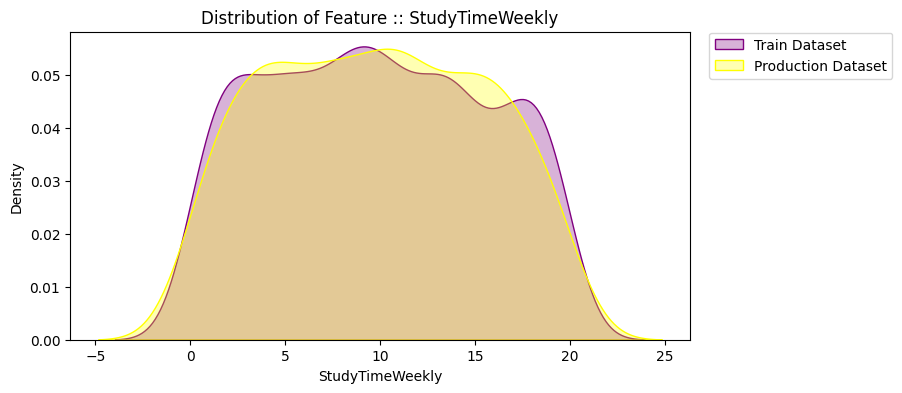

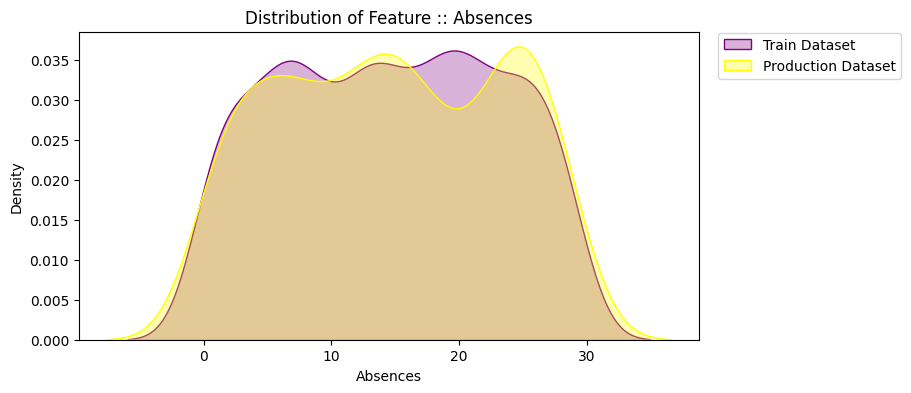

In [ ]:
for num_feature in num_vars:
  plt.figure(figsize=(8,4))

  # Plotting the KDE Plot for Train dataset and then for Production Dataset
  sn.kdeplot(trainDataset_df[num_feature], alpha=0.3, color='purple', fill=True, label='Train Dataset')

  sn.kdeplot(prodDataset_df[num_feature], alpha=0.3, color='yellow', fill=True, label='Production Dataset')

  # Title, x-label and y-label for each plot
  plt.title(f"Distribution of Feature :: {num_feature}")
  plt.xlabel(num_feature)
  plt.ylabel("Density")
  plt.legend(bbox_to_anchor=(1.02, 1.02), loc='upper left')
  plt.show()

**Categorical Data Feature**

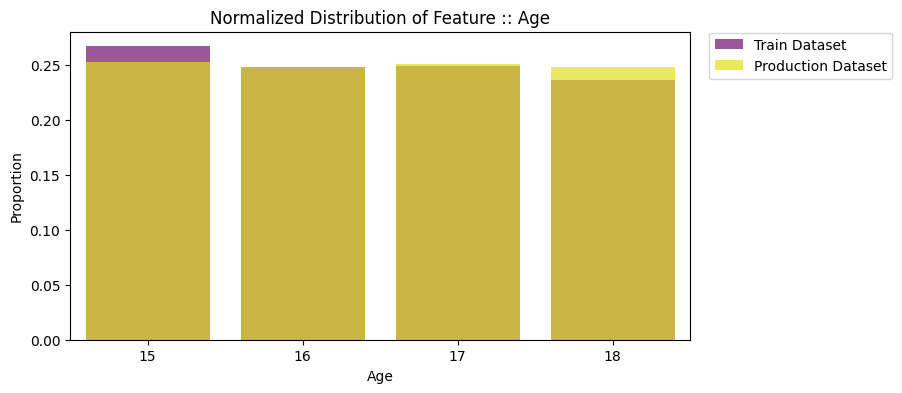

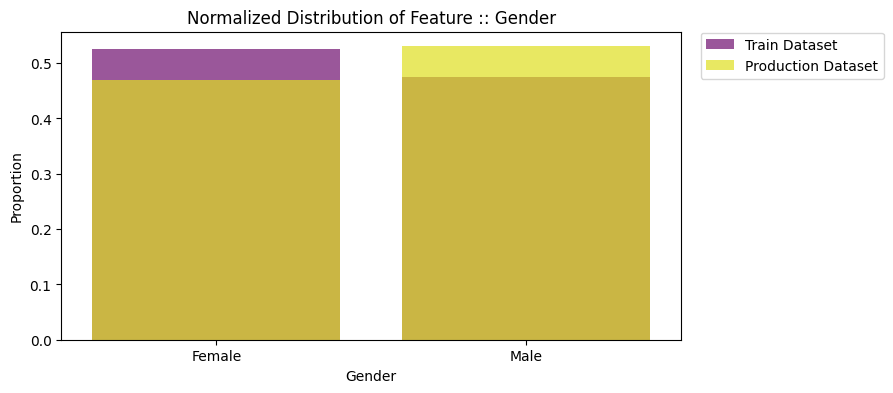

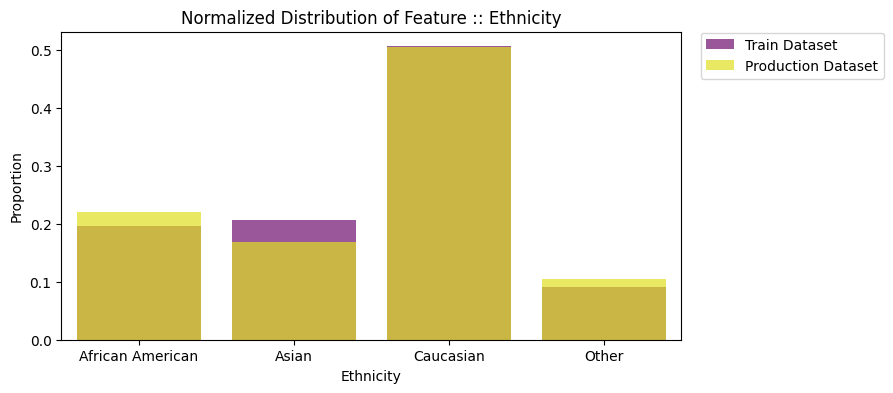

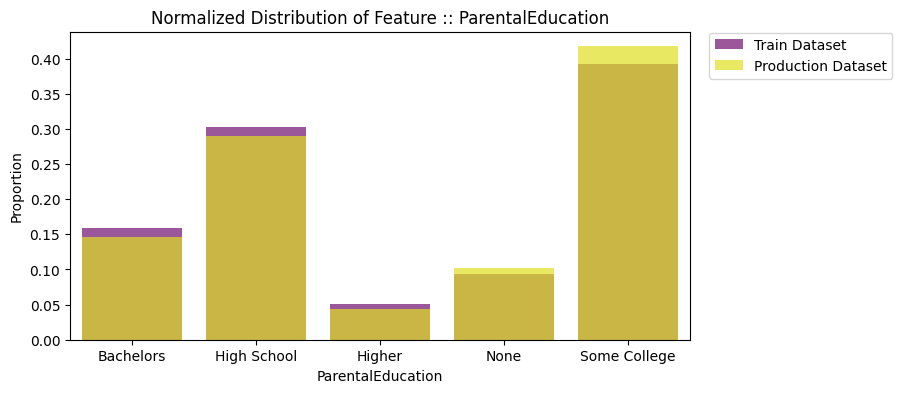

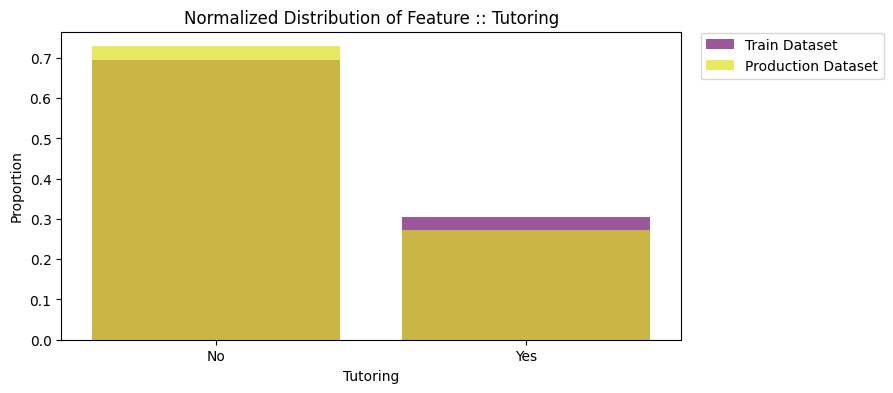

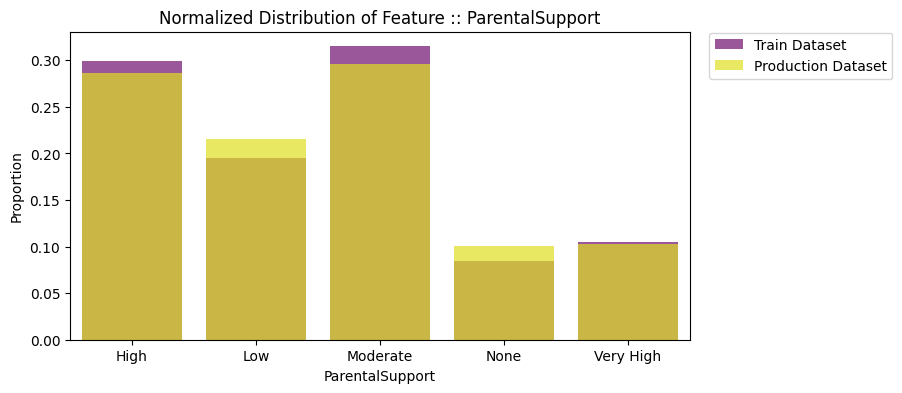

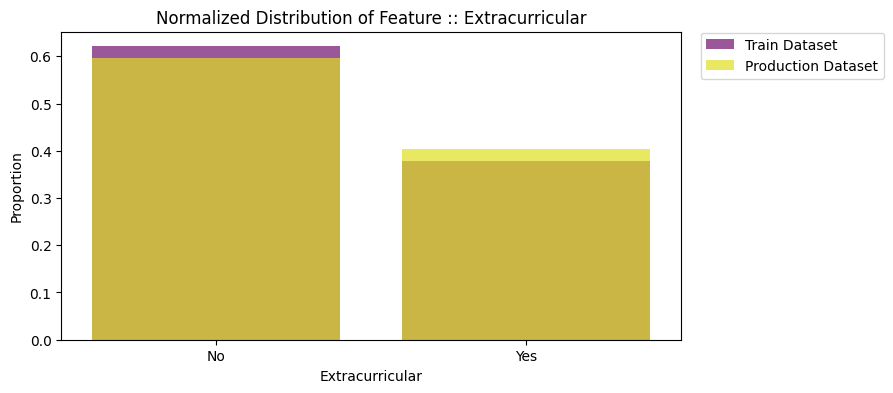

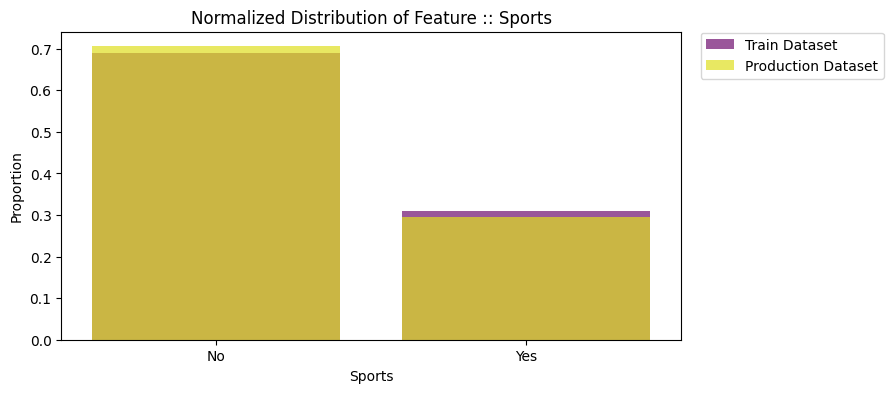

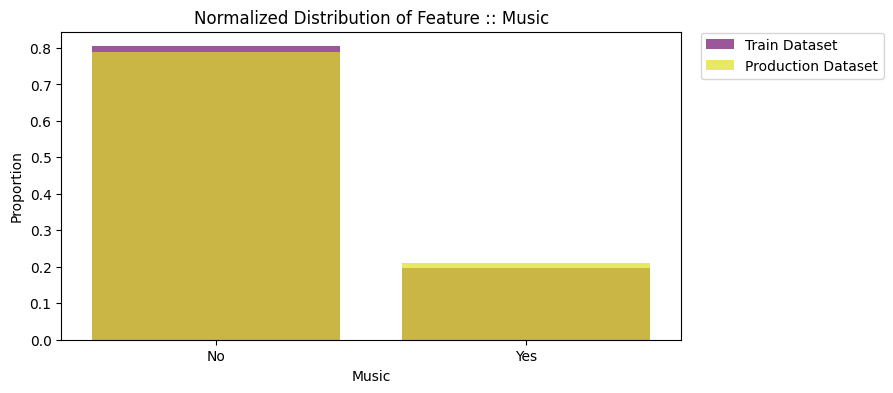

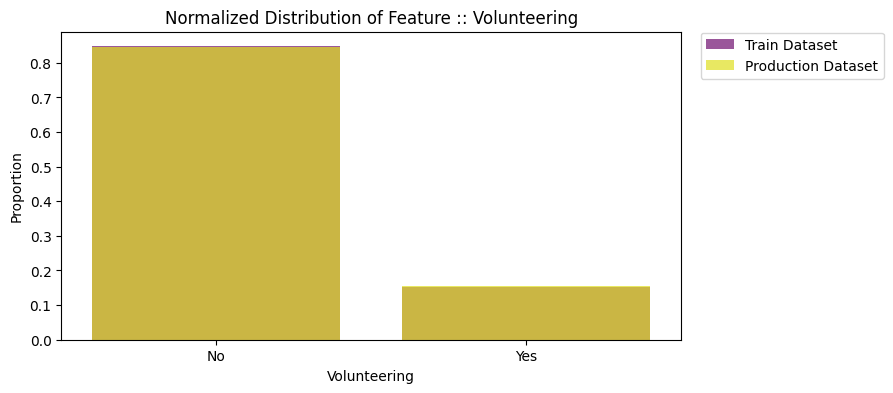

In [ ]:
for categorical in catg_vars:

  value_mappings = {
    "Age": {15: 15, 16: 16, 17: 17, 18: 18},
    "Gender": {0: "Male", 1: "Female"},
    "Ethnicity": {0: "Caucasian", 1: "African American", 2: "Asian", 3: "Other"},
    "ParentalEducation": {0: "None", 1: "High School", 2: "Some College", 3: "Bachelors", 4: "Higher"},
    "Tutoring": {0: "No", 1: "Yes"},
    "ParentalSupport": {0: "None", 1: "Low", 2: "Moderate", 3: "High", 4: "Very High"},
    "Extracurricular": {0: "No", 1: "Yes"},
    "Sports": {0: "No", 1: "Yes"},
    "Music": {0: "No", 1: "Yes"},
    "Volunteering": {0: "No", 1: "Yes"}
  }

  trainDataset_df[categorical] = trainDataset_df[categorical].map(value_mappings[categorical])
  prodDataset_df[categorical] = prodDataset_df[categorical].map(value_mappings[categorical])

  plt.figure(figsize=(8, 4))

  # Plotting the Bar Plot for Train dataset and then for Production Dataset
  # Grouping and normalizing values for the train dataset
  grouped_train = trainDataset_df.groupby(categorical).size()
  normalized_train = grouped_train / grouped_train.sum()
  grouped_train

  sn.barplot(x=grouped_train.index, y=normalized_train.values, alpha=0.7, color='purple', label='Train Dataset')

  # Grouping and normalizing values for the production dataset
  grouped_prod = prodDataset_df.groupby(categorical).size()
  normalized_prod = grouped_prod / grouped_prod.sum()
  grouped_prod

  sn.barplot(x=grouped_prod.index, y=normalized_prod.values, alpha=0.7, color='yellow', label='Production Dataset')

  # Adding title and labels
  plt.title(f"Normalized Distribution of Feature :: {categorical}")
  plt.xlabel(categorical)
  plt.ylabel("Proportion")
  plt.legend(bbox_to_anchor=(1.02, 1.02), loc='upper left')
  plt.show()

In [ ]:
for categorical in catg_vars:
  # Grouping and normalizing values for the train dataset
  grouped_train = trainDataset_df.groupby(categorical).size()


  # Grouping and normalizing values for the production dataset
  grouped_prod = prodDataset_df.groupby(categorical).size()

  print(f"Feature ::{categorical}")
  table_df = pd.DataFrame({'categories' : grouped_train.index,
               'train_value' : grouped_train.values,
               'prod_value' : grouped_prod.values})
  print(table_df)
  print("\n")

Feature ::Age
   categories  train_value  prod_value
0          15          383         121
1          16          356         119
2          17          357         120
3          18          339         119


Feature ::Gender
  categories  train_value  prod_value
0     Female          753         225
1       Male          682         254


Feature ::Ethnicity
         categories  train_value  prod_value
0  African American          281         106
1             Asian          297          81
2         Caucasian          727         242
3             Other          130          50


Feature ::ParentalEducation
     categories  train_value  prod_value
0     Bachelors          229          70
1   High School          434         139
2        Higher           73          21
3          None          135          49
4  Some College          564         200


Feature ::Tutoring
  categories  train_value  prod_value
0         No          997         349
1        Yes          438         130
